__File: src_physics_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Apr 09, 2021__

Generates SRC physics figures. Each function returns a matplotlib figure which can be saved using f.savefig(). Arguments of the plotting functions change either what is plotted or customizations of the figure. Further customization can be done outside the plotting functions (e.g., things like ax.legend(), ax.add_artist(), etc.) Use this notebook in conjunction with data files generated by src_physics_write_data.ipynb.

__Revision history:<br/>__
* Apr 13, 2021 - Finished the following functions: n_lambda_deuteron_decomposition, srg_transformation_partial_wave_ratios, snmd_tails, pp_pn_pmd_ratios, p_n_pmd_ratios, and a2_scaling_factors.
* Apr 15, 2021 - Adding experimental $a_2$ values to a2_scaling_factors figures.
* Apr 16, 2021 - Updating momentum distribution figures with inclusion of Fe56. Also updated $a_2$ plot to only distinguish marker types and colors between my values and experimental values.
* Apr 22, 2021 - Created a2_scaling_factors_with_errorbars to plot average results from a2_scaling_factors function but with error bars. a2_scaling_factors only deals with one set of integration limits whereas a2_scaling_factors_with_errorbars varies two sets of integration limits.
* Apr 28, 2021 - Added snmd_with_AV18_vary_lambda under Extras to look at single-nucleon momentum distributions varying with SRG $\lambda$.
* Apr 29, 2021 - Generating figures for new momentum mesh with $k_{\rm max}=15$ fm$^{-1}$.
* May 05, 2021 - Added snmd_with_AV18_multiplot to show all nuclei in a multiplot figure

In [1]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
# Scripts made by A.T.
from Figures import figures_functions as ff # This also exists in Dropbox

__Set-up__

In [2]:
# Save figures in the following directory (you can change this in the Dropbox)
figure_directory = 'Figures/SRC_physics'

# Specify potential
kvnn = 6 # AV18
# kvnn = 222 # Gezerlis N2LO 1 fm
# kvnn = 224 # Gezerlis N2LO 1.2 fm

# Load data from the following directory
data_directory = 'Figures/SRC_physics/Data/kvnn_%s' % kvnn
exp_data_directory = 'Figures/SRC_physics/Data' # Data from experiments

# Specify which momentum mesh you want to use
# kmax, kmid, ntot = 10.0, 2.0, 120 # Mesh artifacts seen in last few points of 3S1-3D1 \delta U for AV18
kmax, kmid, ntot = 15.0, 3.0, 120

# SRG evolve to 1.35 fm^-1
lamb = 1.35 

# Channels to include in calculation of momentum distributions
channels = ('1S0', '3S1') # S-waves only
# channels = ('1S0', '3S1', '3P0', '1P1', '3P1') # Still having issue with '3P2' and '3D3'

# Nuclei to show
nuclei = ( ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Fe56', 26, 30),
           ('Pb208', 82, 126) )

# For converting x-axis from fm^-1 to MeV
hbar_c = 197.326 # MeV*fm

# Be careful that you don't overwrite these variables in other cells (e.g., writing 'for lamb in lambdas:')

In [3]:
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """
    
    # Changes by A.T.
    # Setting the axes, title, and legend font sizes within the plotting functions not here
    
    if presentation:
        fontsize = 11
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot (over the axes border)
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by A.T.
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)
#     mpl.rcParams['legend.borderaxespad'] = 0.8
    # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['legend.framealpha'] = None
    # This is for legend edgewidth, since it does not have its own option
    mpl.rcParams['patch.linewidth'] = 0.8
    mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [4]:
# Run this cell to customize matplotlib graphics (see setup_rc_params for details)

setup_rc_params(presentation=True)
# setup_rc_params(presentation=False)

__Decomposition of $n^{\lambda}_d(q)$__

In [10]:
def n_lambda_deuteron_decomposition(kvnn, lamb, kmax=10.0, kmid=2.0, ntot=120, curves=4, xlim=(0, 4),
                                    ylim=(1e-5, 1e3)):
    """
    SRG-evolved deuteron pair momentum distribution as calculated by our expansion of U(k, k') in second
    quantization using deuteron wave function (not LDA). Gives each of the contributions from 1, \delta U,
    \delta U \delta U^\dagger.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    curves : int
        Number of curves to be plotted starting with the full high-resolution result, then the 1 term,
        \delta U, term, and finally \delta U \delta U^{\dagger} term.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3]. If ylim[0] <= 0, plots on a linear y-scale.
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Make sure the number of curves makes sense
    # Can only go from 1 to 4
    if not ( curves in range(1, 5) ):
        print('Invalid number of curves. Must specify an integer from 1-4.')
        return None

    # Data file name
    file_name = 'n_lambda_deuteron_decomposition_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
    file_name = ff.replace_periods(file_name) + '.dat'
    
    # Load momentum and momentum distribution contributions for given potential
    data = np.loadtxt(data_directory + '/' + file_name)
    q_array = data[:, 0] # Momentum in fm^-1
    n_d_total_array = data[:, 1] # Total momentum distribution in fm^3
    n_d_1_array = data[:, 2] # Contribution from 1 term
    n_d_deltaU_array = data[:, 3] # Contribution from \delta U term
    n_d_deltaU2_array = data[:, 4] # Contribution from \delta U^2 term
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$n^{\lambda}_d(q)$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 18
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Linear scale
    if ylim[0] <= 0.0:
        
        # Plot total
        ax.plot(q_array, n_d_total_array, color='xkcd:black', label='High res.', linestyle='solid',
                    linewidth=curve_width)
        # Plot 1 term
        if curves > 1:
            ax.plot(q_array, n_d_1_array, color='xkcd:blue', label='1', linestyle='dotted',
                    linewidth=curve_width)
        # Plot \delta U term
        if curves > 2:
            ax.plot(q_array, n_d_deltaU_array, color='xkcd:green', label=r'$\delta U$', linestyle='dashed',
                    linewidth=curve_width)
        # Plot \delta U^2 term
        if curves > 3:
            ax.plot(q_array, n_d_deltaU2_array, color='xkcd:red', label=r'$\delta U \delta U^{\dagger}$',
                    linestyle='dashdot', linewidth=curve_width)        
        
    # Log scale
    else:
        
        ax.semilogy(q_array, n_d_total_array, color='xkcd:black', label='High res.', linestyle='solid',
                    linewidth=curve_width)
        # Plot 1 term
        if curves > 1:
            ax.semilogy(q_array, n_d_1_array, color='xkcd:blue', label='1', linestyle='dotted',
                        linewidth=curve_width)
        # Plot \delta U term (take absolute value!)
        if curves > 2:
            ax.semilogy(q_array, abs(n_d_deltaU_array), color='xkcd:green', label=r'$|\delta U|$',
                        linestyle='dashed', linewidth=curve_width)
        # Plot \delta U^2 term
        if curves > 3:
            ax.semilogy(q_array, n_d_deltaU2_array, color='xkcd:red',
                        label=r'$\delta U \delta U^{\dagger}$', linestyle='dashdot', linewidth=curve_width)
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

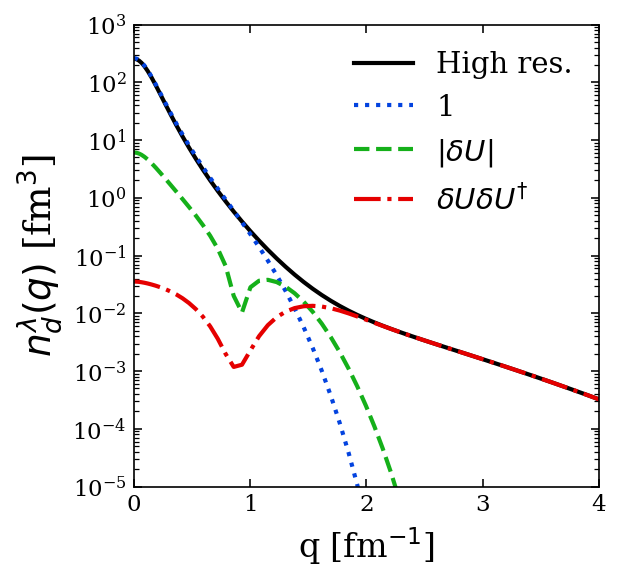

In [11]:
# Contributions to deuteron momentum distribution in terms of 1, \delta U, and \delta U^2

curves_tuple = (1, 2, 3, 4) # Number of curves to be plotted
xlim = (0, 4)
ylim = (1e-5, 1e3) # Log-scale y-axis

# Loop over the number of contributions you want showing on the figure
for curves in curves_tuple:
    
    f, ax = n_lambda_deuteron_decomposition(kvnn, lamb, kmax, kmid, ntot, curves, xlim, ylim)
    
    # Add legend
    legend_size = 14
    legend_location = 'upper right'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

    # Set file name
    file_name = 'n_lambda_deuteron_decomposition_kvnn_%d_lamb_%.2f_kmax_%.1f_curves_%d' % (kvnn, lamb, kmax,
                                                                                           curves)
    file_name = ff.replace_periods(file_name) + '.png'

    # Save figure
    f.savefig(figure_directory + '/' + file_name)

__($^{3}S_1-^{3}D_1$) / $^{1}S_0$ SRG transformation ratio__

In [7]:
def srg_transformation_partial_wave_ratios(k_0, kvnns, lamb, kmax=10.0, kmid=2.0, ntot=120, xlim=(0, 4),
                                           ylim=(1e0, 1e3)):
    """
    Ratio of |U(k_0, q)_{3S1-3D1}|^2 / |U(k_0, q)_{1S0}|^2 where k_0 < \lambda.
    
    Parameters
    ----------
    k_0 : float
        k_0 value in the ratio U(k_0, q)_{3S1} / U(k_0, q)_{1S0} [fm^-1].
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$|U_{\lambda}(k_0, q)|^2$' + ' ratio'
    y_label_size = 18
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over kvnns
    for i, kvnn in enumerate(kvnns):
        
        # Data file name
        file_name = 'srg_transformation_partial_wave_ratios_k_0_%.1f_kvnn_%d_lamb_%.2f_kmax_%.1f' % \
                    (k_0, kvnn, lamb, kmax)
        file_name = ff.replace_periods(file_name) + '.dat'
        
        # Load momentum and ratios
        data = np.loadtxt('Figures/SRC_physics/Data/kvnn_%s' % kvnn + '/' + file_name)
        q_array = data[:, 0] # Momentum in fm^-1
        ratio_array = data[:, 1] # 3S1-3D1 / 1S0 ratio

        # Curve color and label
        curve_color = ff.xkcd_colors(i+1) # Skip xkcd:black
        curve_label = ff.kvnn_label_conversion(kvnn) # Labels the potential
        
        # Add curve to figure
        ax.semilogy(q_array, ratio_array, color=curve_color, label=curve_label, linestyle='solid',
                    linewidth=curve_width)
        
    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

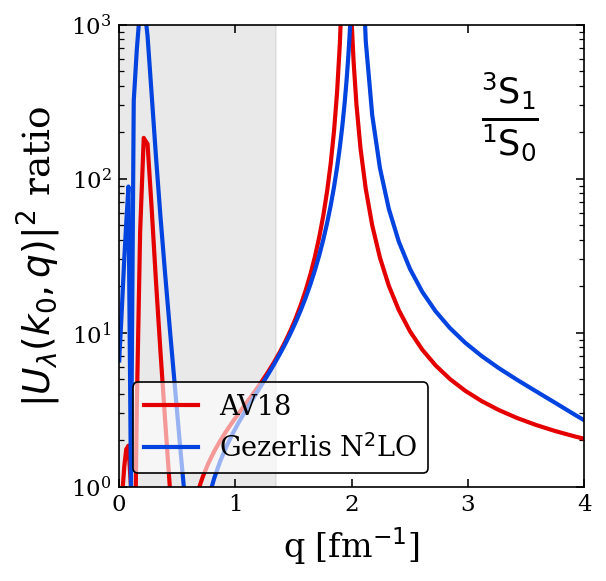

In [8]:
# U_{3S1-3D1} / U_{1S0} ratios for AV18 and Gezerlis N2LO 1 fm with k_0=0.1 fm^-1

k_0 = 0.1
kvnns = (6, 222)
xlim = (0, 4)
ylim = (1e0, 1e3) # Log-scale y-axis

f, ax = srg_transformation_partial_wave_ratios(k_0, kvnns, lamb, kmax, kmid, ntot, xlim, ylim)

# # Add k_0 and \lambda label to plot as title
# label = r'$k_0=%.1f$' % k_0 + ' and ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 14
# ax.set_title(label, fontsize=label_size)
    
# Add legend
legend_size = 13
legend_location = 'lower left'
ax.legend(loc=legend_location, frameon=True, fontsize=legend_size)

# # Add 3S1-3D1 / 1S0 label
# ratio_label = r'$\frac{^3{\rm S}_1\endash^3{\rm D}_1}{^{1}{\rm S}_0}$'
# ratio_label_size = 20
# Add 3S1 / 1S0 label (no 3D1 part)
ratio_label = r'$\frac{^3{\rm S}_1}{^{1}{\rm S}_0}$'
ratio_label_location = 'upper right'
ratio_label_size = 24
anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
                             frameon=False)
ax.add_artist(anchored_text)

# Set file name
file_name = 'srg_transformation_ratios_k0_%.1f_lamb_%.2f_kvnns' % (k_0, lamb)
for ikvnn in kvnns:
    file_name += '_%d' % ikvnn
file_name += '_kmax_%.1f' % kmax
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

__Universality of pair momentum distributions $n_{\lambda}^A(q,Q=0)$ under LDA__

In [9]:
def snmd_tails(nuclei, channels, kvnn, lamb, kmax=10.0, kmid=2.0, ntot=120, xlim=(2, 6), ylim=(1e-2, 1e4)):
    """
    Nuclear-averaged and SRG-evolved proton momentum distributions n_\lambda^A(q) / Z. This figure illustrates
    universality in the momentum distributions. Each distribution's functional dependence is given by a high-q
    function fixed by 2-body. (Dividing by Z means the low-q piece should be roughly the same for every
    nucleus.)
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as another tuple:
        (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = 'proton ' + r'$n^{\lambda}_A(q)/Z$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Name of nucleus (e.g., 'Ca40')
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        
        # Data file name
        file_name = 'lda_snmd_%s_channels' % nucleus_name
        # Add each channel to file name
        for channel in channels:
            file_name += '_%s' % channel
        file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
        file_name = ff.replace_periods(file_name) + '.dat'
        
        # Load momentum and single-nucleon momentum distributions
        data = np.loadtxt(data_directory + '/' + file_name)
        # Momentum in fm^-1
        q_array = data[:, 0]
        # Proton momentum distribution scaled up by overall factor and divided by Z
        n_p_array = data[:, 1] / Z

        # Curve color, line style, and legend label
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = ff.nuclei_label_conversion(nucleus_name) # Labels the nucleus
        
        # Add curve to figure
        ax.semilogy(q_array, n_p_array, color=curve_color, linestyle=curve_style, label=curve_label,
                    linewidth=curve_width)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

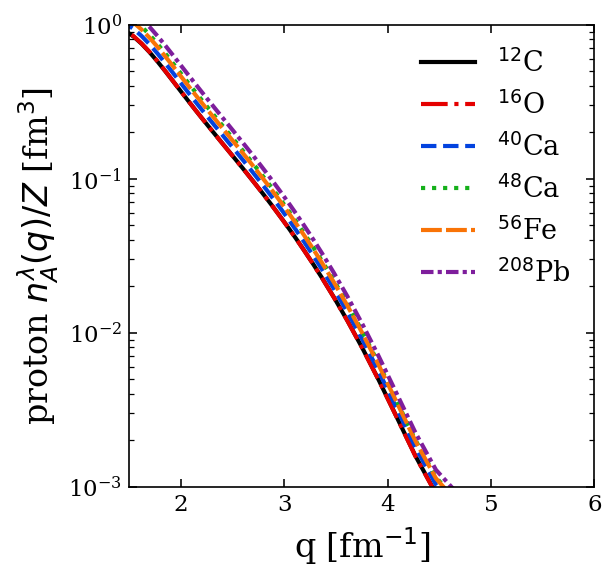

In [10]:
# Universality of single-nucleon momentum distribution tails

xlim = (1.5, 6) # Show only tail end of momentum distributions
ylim=(1e-3, 1e0)

f, ax = snmd_tails(nuclei, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# Add legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'snmd_tails'
# Add each nucleus to file name
for inucleus in nuclei:
    file_name += '_%s' % inucleus[0]
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
# Replace periods
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [11]:
def snmd_tails_with_AV18(nucleus, channels, kvnn, lamb, kmax=10.0, kmid=2.0, ntot=120, xlim=(2, 6),
                         ylim=(1e-2, 1e4)):
    """
    Nuclear-averaged and SRG-evolved proton momentum distributions n_\lambda^A(q) / Z. This figure compares
    our LDA momentum distributions with AV18 data.
    
    Parameters
    ----------
    nucleus : tuple
        Details for various nuclei formatted as a tuple: (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = 'proton ' + r'$n^{\lambda}_A(q)/Z$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Name of nucleus (e.g., 'Ca40')
    nucleus_name = nucleus[0]
    Z = nucleus[1]
        
    # Data file name
    file_name = 'lda_snmd_%s_channels' % nucleus_name
    # Add each channel to file name
    for channel in channels:
        file_name += '_%s' % channel
    file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
    file_name = ff.replace_periods(file_name) + '.dat'
        
    # Load momentum and single-nucleon momentum distributions
    data = np.loadtxt(data_directory + '/' + file_name)
    # Momentum in fm^-1
    q_array = data[:, 0]
    # Proton momentum distribution scaled up by overall factor and divided by Z
    n_p_array = data[:, 1] / Z

    # Legend label
    curve_label = ff.nuclei_label_conversion(nucleus_name) # Labels the nucleus
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Add curve to figure
    ax.plot(q_array, n_p_array, color='xkcd:red', label=curve_label, linewidth=curve_width)
        
    # Add AV18 data with error bars
    av18_data = np.loadtxt(exp_data_directory + '/' + 'AV18_%s_snmd.txt' % nucleus_name)
    q_array_av18 = av18_data[:, 0] # fm^-1
    n_p_array_av18 = av18_data[:, 1] / Z
    error_bars_array_av18 = av18_data[:, 2] / Z
            
    # AV18 data with error bars
    ax.errorbar(q_array_av18, n_p_array_av18, yerr=error_bars_array_av18, color='xkcd:black', label='AV18',
                linestyle='', marker='.')

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

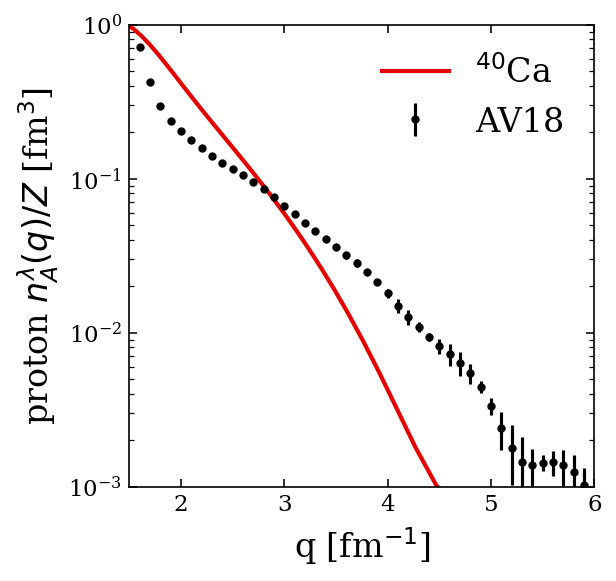

In [12]:
# Compare proton momentum distributions to AV18 data

av18_nuclei = ( ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20) )
xlim = (1.5, 6) # Show only tail end of momentum distributions
ylim=(1e-3, 1e0)

# Loop over AV18 nuclei
for inucleus in av18_nuclei:
    
    f, ax = snmd_tails_with_AV18(inucleus, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

    # Add legend
    legend_size = 16
    legend_location = 'upper right'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

    # Set file name
    file_name = 'snmd_tails_with_AV18_%s' % inucleus[0]
    # Add each channel to file name
    file_name += '_channels'
    for ichannel in channels:
        file_name += '_%s' % ichannel
    file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
    # Replace periods
    file_name = ff.replace_periods(file_name) + '.png'

    # Save figure
    f.savefig(figure_directory + '/' + file_name)

In [16]:
def snmd_tails_with_AV18_multiplot(nuclei, channels, kvnn, lamb, kmax=10.0, kmid=2.0, ntot=120, xlim=(2, 6),
                                   ylim=(1e-2, 1e4)):
    """
    Nuclear-averaged and SRG-evolved proton momentum distributions n_\lambda^A(q) / Z. This figure compares
    our LDA momentum distributions with AV18 data showing all nuclei on the same figure. This is a 1 x 3
    subplots figure.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as another tuple:
        (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    # Figure size
    row_number = 1
    col_number = 3
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = 'proton ' + r'$n^{\lambda}_A(q)/Z$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
    
        # Name of nucleus (e.g., 'Ca40')
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        
        # Data file name
        file_name = 'lda_snmd_%s_channels' % nucleus_name
        # Add each channel to file name
        for channel in channels:
            file_name += '_%s' % channel
        file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
        file_name = ff.replace_periods(file_name) + '.dat'
        
        # Load momentum and single-nucleon momentum distributions
        data = np.loadtxt(data_directory + '/' + file_name)
        # Momentum in fm^-1
        q_array = data[:, 0]
        # Proton momentum distribution scaled up by overall factor and divided by Z
        n_p_array = data[:, 1] / Z

        # Legend label
        curve_label = ff.nuclei_label_conversion(nucleus_name) # Labels the nucleus
        
        # Set y-axis to log scale
        axs[i].set_yscale('log')
    
        # Add curve to figure
        axs[i].plot(q_array, n_p_array, color='xkcd:red', label=curve_label, linewidth=curve_width)
        
        # Add AV18 data with error bars
        av18_data = np.loadtxt(exp_data_directory + '/' + 'AV18_%s_snmd.txt' % nucleus_name)
        q_array_av18 = av18_data[:, 0] # fm^-1
        n_p_array_av18 = av18_data[:, 1] / Z
        error_bars_array_av18 = av18_data[:, 2] / Z
            
        # AV18 data with error bars
        axs[i].errorbar(q_array_av18, n_p_array_av18, yerr=error_bars_array_av18, color='xkcd:black',
                    label='AV18', linestyle='', marker='.')

        # Specify axes limits
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        
        # Set axes labels and legend
        axs[i].set_xlabel(x_label, fontsize=x_label_size)
        if i == 0: # First subplot (from left to right)
            axs[i].set_ylabel(y_label, fontsize=y_label_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.05)

    return f, axs

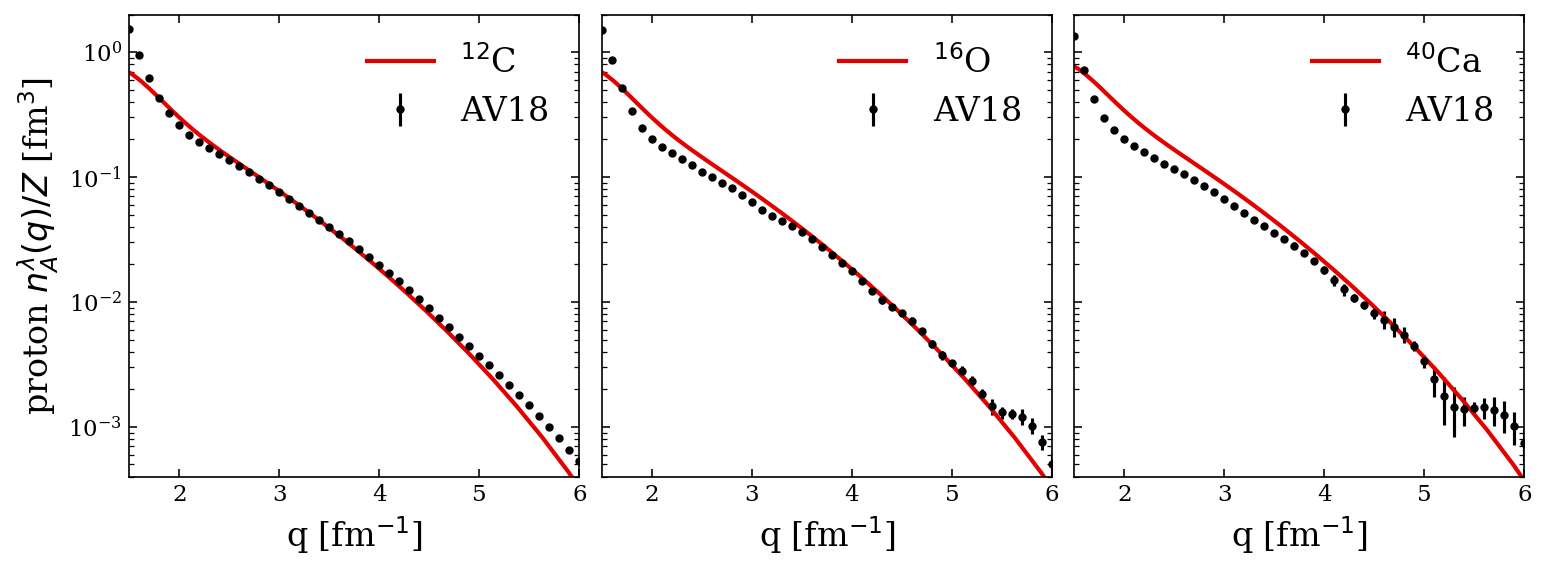

In [23]:
# Compare proton momentum distributions to AV18 data in one figure

av18_nuclei = ( ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20) )
xlim = (1.5, 6) # Show only tail end of momentum distributions
ylim=(4e-4, 2e0)

f, axs = snmd_tails_with_AV18_multiplot(av18_nuclei, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# Add legends
legend_size = 16
legend_location = 'upper right'
# Loop over each subplot
for i, nucleus in enumerate(av18_nuclei):

    # Add legend
    axs[i].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'snmd_tails_with_AV18_multiplot'
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
# Replace periods
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

__pp/pn ratios of $n_{\lambda}^A(q,Q=0)$ under LDA__

In [9]:
def pp_pn_pmd_ratios(nuclei, channels, kvnn, lamb, kmax=0.0, kmid=0.0, ntot=0, xlim=(0, 4), ylim=(0, 1)):
    """
    Ratio of pp/pn pair momentum distributions in nuclei under LDA.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as another tuple:
        (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$n^{\lambda}_A(q,Q=0)$' + ' ratio'
    y_label_size = 18
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Name of nucleus (e.g., 'Ca40')
        nucleus_name = nucleus[0]
        
        # Data file name
        file_name = 'lda_pmd_%s_channels' % nucleus_name
        # Add each channel to file name
        for channel in channels:
            file_name += '_%s' % channel
        file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
        file_name = ff.replace_periods(file_name) + '.dat'
        
        # Load momentum and pair momentum distributions
        data = np.loadtxt(data_directory + '/' + file_name)
        q_array = data[:, 0] # Momentum in fm^-1
        n_pp_array = data[:, 1] # Proton-proton momentum distribution
        n_pn_array = 2 * data[:, 2] # Proton-neutron + neutron-proton momentum distribution
        ratio_array = n_pp_array / n_pn_array
        
        # Curve color, line style, and legend label
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = ff.nuclei_label_conversion(nucleus_name) # Labels the nucleus
        
        # Add curve to figure
        ax.plot(q_array, ratio_array, color=curve_color, linestyle=curve_style, label=curve_label,
                linewidth=curve_width)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

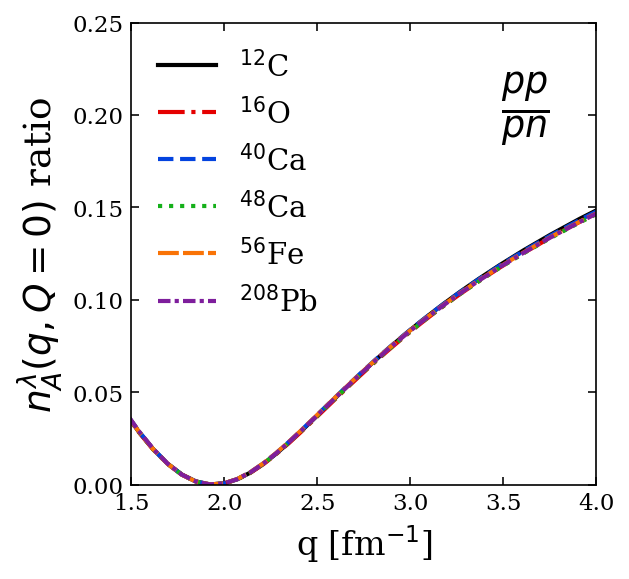

In [12]:
# pp/pn pair momentum distribution ratios

xlim = (1.5, 4) # Just show high-q tail
ylim = (0.0, 0.25)

f, ax = pp_pn_pmd_ratios(nuclei, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# Add legend for nuclei
legend_size = 14
legend_location = 'upper left'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Add pp/pn label
ratio_label = r'$\frac{pp}{pn}$'
ratio_label_location = 'upper right'
ratio_label_size = 25
anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
                             frameon=False)
ax.add_artist(anchored_text)

# Set file name
file_name = 'pp_pn_pmd_ratios'
# Add each nucleus to file name
for inucleus in nuclei:
    file_name += '_%s' % inucleus[0]
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

__$\frac{pp+pn}{nn+np}$ ratios of $n_{\lambda}^A(q,Q=0)$ under LDA__

In [13]:
def p_n_pmd_ratios(nuclei, channels, kvnn, lamb, kmax=0.0, kmid=0.0, ntot=0, xlim=(0, 4), ylim=(0.5, 1.5)):
    """
    Ratio of (pp+pn)/(nn+np) pair momentum distributions in nuclei under LDA.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as another tuple:
        (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$n^{\lambda}_A(q,Q=0)$' + ' ratio'
    y_label_size = 18
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Name of nucleus (e.g., 'Ca40')
        nucleus_name = nucleus[0]
        
        # Data file name
        file_name = 'lda_pmd_%s_channels' % nucleus_name
        # Add each channel to file name
        for channel in channels:
            file_name += '_%s' % channel
        file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
        file_name = ff.replace_periods(file_name) + '.dat'
        
        # Load momentum and pair momentum distributions
        data = np.loadtxt(data_directory + '/' + file_name)
        q_array = data[:, 0] # Momentum in fm^-1
        n_pp_array = data[:, 1] # Proton-proton momentum distribution
        n_pn_array = data[:, 2] # Proton-neutron (neutron-proton) momentum distribution
        n_nn_array = data[:, 3] # Proton-neutron (neutron-proton) momentum distribution
        ratio_array = (n_pp_array + n_pn_array) / (n_nn_array + n_pn_array)
        
        # Curve color, line style, and legend label
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = ff.nuclei_label_conversion(nucleus_name) # Labels the nucleus
        
        # Add curve to figure
        ax.plot(q_array, ratio_array, color=curve_color, linestyle=curve_style, label=curve_label,
                linewidth=curve_width)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

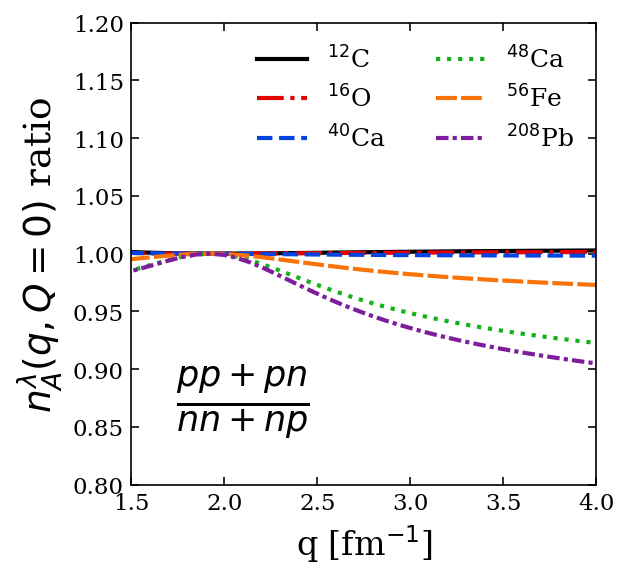

In [14]:
# (pp+pn)/(nn+np) pair momentum distribution ratios

xlim = (1.5, 4)
ylim = (0.8, 1.2)

f, ax = p_n_pmd_ratios(nuclei, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# Add legend label for nuclei
# legend_size = 14
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Add (pp+pn)/(nn+np) label
ratio_label = r'$\frac{pp+pn}{nn+np}$'
# ratio_label_location = 'upper right'
ratio_label_location = 'lower left'
ratio_label_size = 24
anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
                             frameon=False)
ax.add_artist(anchored_text)

# Set file name
file_name = 'p_n_pmd_ratios'
# Add each nucleus to file name
for inucleus in nuclei:
    file_name += '_%s' % inucleus[0]
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

__$a_2$ scaling factors__

In [28]:
def a2_scaling_factors(nuclei, channels, kvnn, lamb, integration_limits=(2.0,), kmax=10.0, kmid=2.0,
                       ntot=120, xlim=(1e0, 3e2), ylim=(0.0, 6.0)):
    """
    a_2 scaling factors evaluated using LDA nuclear-averaged, SRG-evolved single-nucleon momentum
    distributions. These factors are defined by
            ( \int_{q_start}^{q_stop} dq P^A(q) ) / ( \int_{q_start}^{q_stop} dq P^d(q) ),
    where P^A(q) is the single-nucleon probability distribution defined by P^A(q) = q^2 n^A(q) / A.
    The integration limits are set to 2-\infty fm^-1 by default.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as another tuple:
        (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    integration_limits : tuple, optional
        Integration limits for a_2 calculation [fm^-1]. If no maximum is specified, then the function
        takes q to \infty.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [unitless].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # Data file name
    file_name = 'a2_scaling_factors_nuclei' # First part of name
    # Add each nucleus to file name
    for nucleus in nuclei:
        file_name += '_%s' % nucleus[0]
    # Add each channel to file name
    file_name += '_channels'
    for channel in channels:
        file_name += '_%s' % channel
    file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
    # Add integration limits to file name
    if len(integration_limits) == 1: # Assumes only minimum specified
        file_name = file_name + '_limits_%.1f_%.1f' % (integration_limits[0], kmax)
    elif len(integration_limits) == 2:
        file_name = file_name + '_limits_%.1f_%.1f' % (integration_limits[0], integration_limits[1])

    # Replace periods
    file_name = ff.replace_periods(file_name) + '.dat'
    
    # Load mass number and a_2 factors
    data = np.loadtxt(data_directory + '/' + file_name)
    A_array = data[:, 0] # Mass numbers
    a2_array = data[:, 1] # a_2 scaling factors
    
    # Experimental values
    data_exp = np.loadtxt(exp_data_directory + '/' + 'Schmookler_a2_C12_Fe56_Pb208.txt')
    A_exp_array = data_exp[:, 0]
    a2_exp_array = data_exp[:, 1]
    a2_err_exp_array = data_exp[:, 2]

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 16
    y_label = r'$a_2$'
    y_label_size = 18

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set log-scale on x-axis
    ax.set_xscale('log')
    
    # Plot all your values at the same time (same markers and color)
    # Offset A by a bit so you can compare results
    
    # Label \lambda value
    marker_label = r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
    
    ax.plot(1.01*A_array, a2_array, color='xkcd:red', marker='o', linestyle='', markersize=7,
            label=marker_label)
    
    # Experimental values
    ax.errorbar(0.99*A_exp_array, a2_exp_array, yerr=a2_err_exp_array, color='xkcd:black', marker='s',
                linestyle='', markersize=7, label='Exp')
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

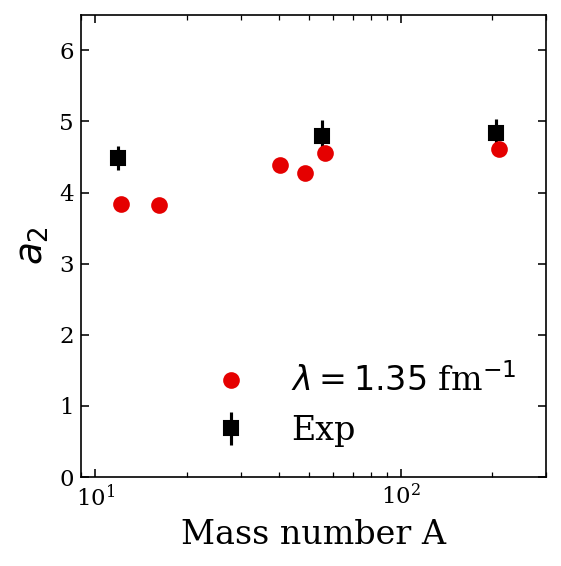

In [29]:
# a_2 scaling factors (integration from 2 to \infty fm^-1)

integration_limits = (2.0,)
xlim = (9e0, 3e2) # Log-scale x-axis
ylim = (0.0, 6.5)

f, ax = a2_scaling_factors(nuclei, channels, kvnn, lamb, integration_limits, kmax, kmid, ntot, xlim, ylim)

# Add legend
legend_size = 16
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'a2_scaling_factors'
# Add each nucleus to file name
for inucleus in nuclei:
    file_name += '_%s' % inucleus[0]
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f_limits_%.1f_%.1f' % (kvnn, lamb, kmax, integration_limits[0], kmax)
# Replace periods
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

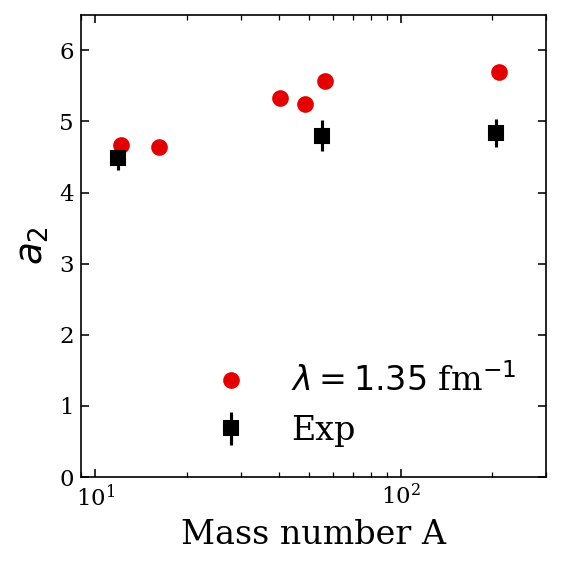

In [30]:
# a_2 scaling factors (integration from 3.8 to 4.5 fm^-1)

integration_limits = (3.8, 4.5)
xlim = (9e0, 3e2) # Log-scale x-axis
ylim = (0.0, 6.5)

f, ax = a2_scaling_factors(nuclei, channels, kvnn, lamb, integration_limits, kmax, kmid, ntot, xlim, ylim)

# Add legend
legend_size = 16
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'a2_scaling_factors'
# Add each nucleus to file name
for inucleus in nuclei:
    file_name += '_%s' % inucleus[0]
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f_limits_%.1f_%.1f' % (kvnn, lamb, kmax, integration_limits[0],
                                                                integration_limits[1])
# Replace periods
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [31]:
def a2_scaling_factors_with_errorbars(nuclei, channels, kvnn, lamb, kmax=10.0,
                                      kmid=2.0, ntot=120, xlim=(1e0, 3e2), ylim=(0.0, 6.0)):
    """
    a_2 scaling factors evaluated using LDA nuclear-averaged, SRG-evolved single-nucleon momentum
    distributions. These factors are defined by
            ( \int_{q_start}^{q_stop} dq P^A(q) ) / ( \int_{q_start}^{q_stop} dq P^d(q) ),
    where P^A(q) is the single-nucleon probability distribution defined by P^A(q) = q^2 n^A(q) / A.
    The integration limits define the mean value and error bars on this figure where the lower and
    upper bounds are set by integration limits (2, \infty) and (3.8, 4.5) fm^-1, respectively.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as another tuple:
        (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [unitless].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # Data file name
    file_name = 'a2_scaling_factors_nuclei' # First part of name
    # Add each nucleus to file name
    for nucleus in nuclei:
        file_name += '_%s' % nucleus[0]
    # Add each channel to file name
    file_name += '_channels'
    for channel in channels:
        file_name += '_%s' % channel
    file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
    
    # Loop over the two integration limits and save data to dictionary where limits serve as key
    integration_limits_list = [ (2,), (3.8, 4.5) ]
    d = {}
    for integration_limits in integration_limits_list:
        
        # Add integration limits to file name
        if len(integration_limits) == 1: # Assumes only minimum specified
            file_name_temp = file_name + '_limits_%.1f_%.1f' % (integration_limits[0], kmax)
        elif len(integration_limits) == 2:
            file_name_temp = file_name + '_limits_%.1f_%.1f' % (integration_limits[0], integration_limits[1])

        # Replace periods
        file_name_temp = ff.replace_periods(file_name_temp) + '.dat'
    
        # Load mass number and a_2 factors
        data = np.loadtxt(data_directory + '/' + file_name_temp)
        A_array = data[:, 0] # Mass numbers (this won't change)
        d[integration_limits] = data[:, 1] # a_2 scaling factors
        
    # Compute average a_2 values and errors
    a2_array = ( d[ integration_limits_list[0] ] + d[ integration_limits_list[1] ] ) / 2
    a2_errors_array = abs( d[ integration_limits_list[0] ] - d[ integration_limits_list[1] ] ) / 2

    # Experimental values
    data_exp = np.loadtxt(exp_data_directory + '/' + 'Schmookler_a2_C12_Fe56_Pb208.txt')
    A_exp_array = data_exp[:, 0]
    a2_exp_array = data_exp[:, 1]
    a2_errors_exp_array = data_exp[:, 2]

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 16
    y_label = r'$a_2$'
    y_label_size = 18

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set log-scale on x-axis
    ax.set_xscale('log')
    
    # Plot all your values at the same time (same markers and color)
    # Offset A by a bit so you can compare results
    
    marker_label = r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
    
    ax.errorbar(1.01*A_array, a2_array, yerr=a2_errors_array, color='xkcd:red', marker='o', linestyle='',
                markersize=7, label=marker_label)
    
    # Experimental values
    ax.errorbar(0.99*A_exp_array, a2_exp_array, yerr=a2_errors_exp_array, color='xkcd:black', marker='s',
                linestyle='', markersize=7, label='Exp')
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

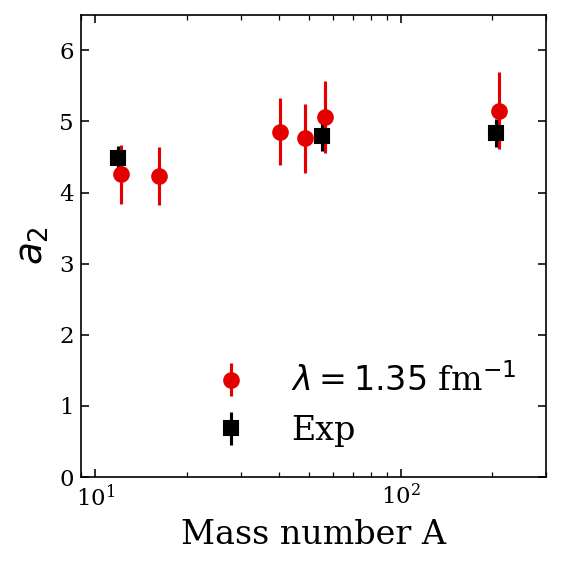

In [33]:
# a_2 scaling factors with error bars

xlim = (9e0, 3e2) # Log-scale x-axis
ylim = (0.0, 6.5)

f, ax = a2_scaling_factors_with_errorbars(nuclei, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# Add legend
legend_size = 16
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'a2_scaling_factors_with_errorbars'
# Add each nucleus to file name
for inucleus in nuclei:
    file_name += '_%s' % inucleus[0]
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
# Replace periods
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

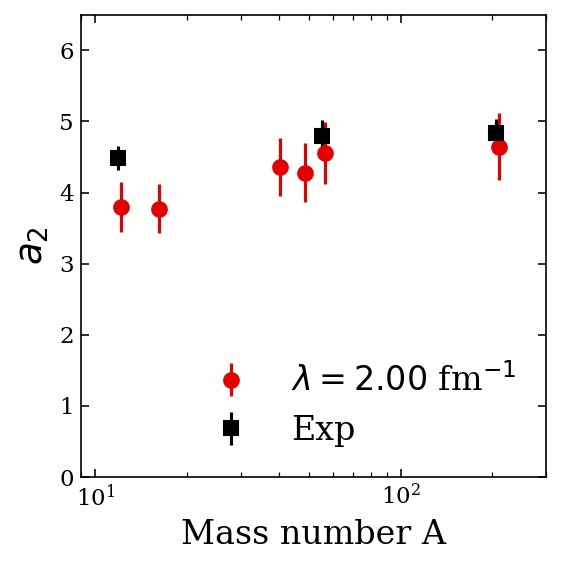

In [34]:
# a_2 scaling factors with error bars with \lambda=1.5 and 2 fm^-1

lambdas = (1.5, 2.0)
xlim = (9e0, 3e2) # Log-scale x-axis
ylim = (0.0, 6.5)

for ilamb in lambdas:
    
    f, ax = a2_scaling_factors_with_errorbars(nuclei, channels, kvnn, ilamb, kmax, kmid, ntot, xlim, ylim)

    # Add legend
    legend_size = 16
    legend_location = 'lower right'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

    # Set file name
    file_name = 'a2_scaling_factors_with_errorbars'
    # Add each nucleus to file name
    for inucleus in nuclei:
        file_name += '_%s' % inucleus[0]
    # Add each channel to file name
    file_name += '_channels'
    for ichannel in channels:
        file_name += '_%s' % ichannel
    file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, ilamb, kmax)
    # Replace periods
    file_name = ff.replace_periods(file_name) + '.png'

    # Save figure
    f.savefig(figure_directory + '/' + file_name)

__Extras__

In [23]:
def snmd_with_AV18_vary_lambda(nucleus, channels, kvnn, lambda_array, kmax=10.0, kmid=2.0, ntot=120,
                               xlim=(0, 6), ylim=(1e-2, 1e4)):
    """
    Nuclear-averaged and SRG-evolved proton momentum distributions n_\lambda^A(q) / Z. This figure compares
    our LDA momentum distributions with AV18 data.
    
    Parameters
    ----------
    nucleus : tuple
        Details for various nuclei formatted as a tuple: (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g., ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lambda_array : 1-D ndarray
        SRG \lambda evolution values [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = 'proton ' + r'$n^{\lambda}_A(q)/Z$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Name of nucleus (e.g., 'Ca40')
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    
    # Plot each for each \lambda value in lambda_array
    for i, lamb in enumerate(lambda_array):
        
        # Data file name
        file_name = 'lda_snmd_%s_channels' % nucleus_name
        # Add each channel to file name
        for channel in channels:
            file_name += '_%s' % channel
        file_name += '_kvnn_%d_lamb_%.2f_kmax_%.1f' % (kvnn, lamb, kmax)
        file_name = ff.replace_periods(file_name) + '.dat'
        
        # Load momentum and single-nucleon momentum distributions
        data = np.loadtxt(data_directory + '/' + file_name)
        # Momentum in fm^-1
        q_array = data[:, 0]
        # Proton momentum distribution scaled up by overall factor and divided by Z
        n_p_array = data[:, 1] / Z

        # Legend label
        curve_label = ff.lambda_label_conversion(lamb) # Labels \lambda
        curve_color = ff.xkcd_colors(i+1) # Skip xkcd:black
        curve_style = ff.line_styles(i)
     
        # Add curve to figure
        ax.plot(q_array, n_p_array, color=curve_color, label=curve_label, linestyle=curve_style,
                linewidth=curve_width)
        
    # Add AV18 data with error bars
    av18_data = np.loadtxt(exp_data_directory + '/' + 'AV18_%s_snmd.txt' % nucleus_name)
    q_array_av18 = av18_data[:, 0] # fm^-1
    n_p_array_av18 = av18_data[:, 1] / Z
    error_bars_array_av18 = av18_data[:, 2] / Z
            
    # AV18 data with error bars
    ax.errorbar(q_array_av18, n_p_array_av18, yerr=error_bars_array_av18, color='xkcd:black', label='AV18',
                linestyle='', marker='.')

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

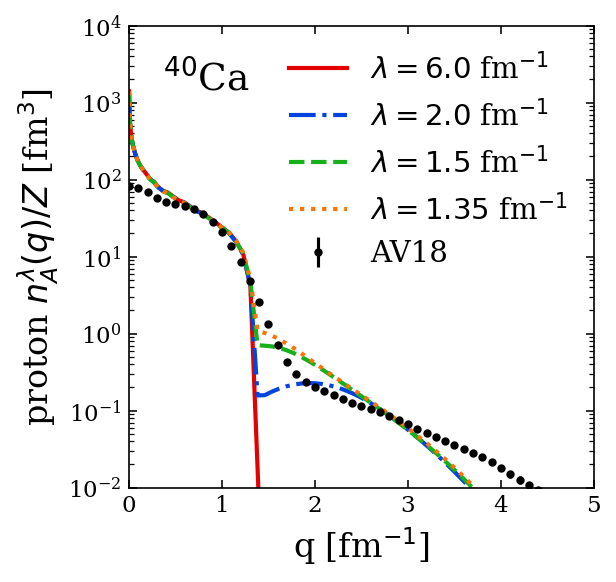

In [24]:
# Plot single-nucleon momentum distributions comparing to AV18 data varying \lambda values

av18_nuclei = ( ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20) )
lambda_array = np.array( (6.0, 2.0, 1.5, 1.35) )
xlim = (0.0, 5.0)
ylim=(1e-2, 1e4)

# Loop over AV18 nuclei
for inucleus in av18_nuclei:
           
    f, ax = snmd_with_AV18_vary_lambda(inucleus, channels, kvnn, lambda_array, kmax, kmid, ntot, xlim, ylim)

    # Add legend
    legend_size = 14
    legend_location = 'upper right'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)
           
    # Add nucleus label
    nucleus_label = ff.nuclei_label_conversion(inucleus[0])
    nucleus_label_location = 'upper left'
    nucleus_label_size = 18
    anchored_text = AnchoredText(nucleus_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
                                 frameon=False)
    ax.add_artist(anchored_text)
           
    # Set file name
    file_name = 'snmd_with_AV18_vary_lambda_%s' % inucleus[0]
    # Add each channel to file name
    file_name += '_channels'
    for ichannel in channels:
        file_name += '_%s' % ichannel
    file_name += '_kvnn_%d_lambdas' % kvnn
    # Add each \lambda to file name
    for ilamb in lambda_array:
        file_name += '_%s' % ff.convert_number_to_string(ilamb)
    file_name += '_kmax_%.1f' % kmax
    # Replace periods
    file_name = ff.replace_periods(file_name) + '.png'

    # Save figure
    f.savefig(figure_directory + '/' + file_name)

In [25]:
# deuteron 3S1 / 3S1-3D1 ratio

In [26]:
# factorization figures

In [27]:
# A/C12 ratio

In [28]:
# S-waves dominance: n^total_S-waves / n^total_SPD-waves

In [29]:
# nuclear contacts

In [30]:
# Numerically check asymptotic relation of SNMD and PMD